In [1]:
import loompy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy_groupies as npg
import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist
import seaborn
import matplotlib as mpl
import gget
import pickle

# suppress INFO
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

# make font changeable in Illustrator
mpl.rcParams['pdf.fonttype'] = 42

# save figure with no pad
mpl.rcParams['savefig.pad_inches'] = 0
mpl.rcParams['savefig.bbox'] = 'tight'

# set axes width
mpl.rcParams['axes.linewidth'] = 0.2
mpl.rcParams['xtick.minor.pad'] = 0
mpl.rcParams['xtick.major.pad'] = 0
mpl.rcParams['ytick.minor.pad'] = 0
mpl.rcParams['ytick.major.pad'] = 0
mpl.rcParams['xtick.minor.width'] = 0.2
mpl.rcParams['xtick.major.width'] = 0.2
mpl.rcParams['ytick.minor.width'] = 0.2
mpl.rcParams['ytick.major.width'] = 0.2

# use colorblind seaborn style
plt.style.use('seaborn-colorblind')

# colors for ROI Groups
color_dict = dict(
    zip(
        ["Cerebral cortex", "Hippocampus", "Cerebral nuclei", "Hypothalamus", "Thalamus", "Midbrain", "Pons", "Cerebellum", "Myelencephalon", "Spinal cord"],
        ['#4682f0', '#8eb7d1', '#89d8e0', '#f28e37', '#e7bc1f', '#43ad78', '#a7236e', '#ed5f8e', '#955ba5', '#eec2a4']
    )
)

In [2]:
folder = '/proj/human_adult/20220222/harmony/paris_top_bug/data/'
figure_folder = '/home/kimberly/figures/revision'

In [3]:
cbl = seaborn.color_palette('colorblind')
cbl

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [113]:
np.arange(6) / 100

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05])

In [122]:
def go_plot(table, n_top=25, filename=None, fig_size=(1,3)):
    
    top = table.sort_values('adj_p_val')[:n_top][::-1]
    
    plt.figure(None, fig_size)
    
    ax = plt.subplot(122)
    plt.barh(range(n_top), top['adj_p_val'].to_numpy(), color='grey', alpha=0.3)
    plt.vlines(0.05, -0.5, n_top-0.5, linestyles='dashed', colors=cbl[2])
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    plt.yticks([])
    plt.xticks(np.arange(6) / 100, rotation=90, fontsize=7)
    plt.margins(y=0.01)
    
    ax = plt.subplot(121)
    n_genes = top['overlapping_genes'].str.len().to_numpy()
    plt.barh(range(n_top), -n_genes, alpha=0.3, color='grey')
    ax.spines.left.set_visible(False)
    ax.spines.top.set_visible(False)
    plt.yticks(range(n_top), top['path_name'].str.split('(').str[0].str.strip(), fontsize=9)
    plt.xticks(
        -np.arange(0, n_genes.max()),
        np.arange(0, n_genes.max()),
        rotation=90,
        fontsize=7
    )
    plt.margins(y=0.01)
    if filename:
        plt.savefig(filename, dpi=300)
    else:
        plt.show()

# Oligodendrocytes

## Prepare pseudobulk counts from a balanced dataset

5000 cells sampled from each donor and type (30,000 cells total)

In [40]:
df = pd.read_csv('/proj/human_adult/20220222/harmony/revision/downsampled_oligo_balanced.csv', index_col=0)
df.head()

,10X362_5:GTCAGCGCACTTCATT,10X362_5:TCCAGAAGTTAGTCGT,10X362_5:GCTGCAGAGACAACTA,10X362_5:CTTTCGGGTTAGTCGT,10X362_5:CTTTCGGCAATAGTAG,10X418_1:GACAGCCGTCCAATCA,10X362_6:TTTCGATGTAGGAGGG,10X362_5:GCACATATCCCACAGG,10X362_5:TGCTCCACACCAGCGT,10X362_5:TCGCTTGGTCGTTCAA,...,10X220_7:ACAGGGAAGGTGCCTC,10X230_5:CCCTCTCTCCCAGGCA,10X230_5:ACGTAACAGGTAGCAC,10X237_1:TTGTGTTTCCATTTGT,10X377_2:GTGTCCTCATGAGTAA,10X230_8:GGTAATCTCTGACGCG,10X349_5:ATGTCTTGTGGATTTC,10X229_5:TTAGGGTGTGTGCCTG,10X318_8:CGCCATTTCACTGTCC,10X264_8:CTCCGATTCGTTCCCA
SLC27A6,0.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
LINC02823,2.0,0.0,0.0,2.0,0.0,2.0,3.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PDE4B-AS1,1.0,1.0,2.0,0.0,1.0,3.0,2.0,3.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MDFIC2,0.0,5.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AL591115.1,27.0,0.0,9.0,0.0,0.0,0.0,43.0,22.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
with loompy.connect('/proj/human_adult/20220222/harmony/paris_top_bug/data/harmony_B_A.agg.loom', 'r') as ds:
    clades = hc.cut_tree(ds.attrs.linkage, 2)

with loompy.connect('/proj/human_adult/20220222/harmony/paris_top_bug/data/harmony_B_A.loom', 'r') as ds:

    # get indices for cells in .csv columns
    cell_dict = dict(zip(ds.ca.CellID, range(ds.shape[1])))
    selected_cells = np.array([cell_dict.get(x) for x in df.columns])

    # get labels
    labels = clades[ds.ca.Clusters].flatten()
    labels = labels[selected_cells]
    donors = ds.ca.Donor[selected_cells]

In [ ]:
df = df.T

In [44]:
df['donor'] = donors
df['condition'] = labels

In [46]:
df.head()

,SLC27A6,LINC02823,PDE4B-AS1,MDFIC2,AL591115.1,AC021915.1,AL118556.2,MIR4300HG,AL392086.3,LINC00326,...,AC025048.1,AC010894.4,CHL1,H4C15,RASSF10,WNT10B,ETNPPL,SYT17,donor,condition
10X362_5:GTCAGCGCACTTCATT,0.0,2.0,1.0,0.0,27.0,2.0,0.0,24.0,5.0,29.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,H19.30.001,0
10X362_5:TCCAGAAGTTAGTCGT,2.0,0.0,1.0,5.0,0.0,0.0,2.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,H19.30.001,0
10X362_5:GCTGCAGAGACAACTA,0.0,0.0,2.0,0.0,9.0,2.0,1.0,0.0,10.0,21.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,H19.30.001,0
10X362_5:CTTTCGGGTTAGTCGT,0.0,2.0,0.0,0.0,0.0,0.0,1.0,9.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,H19.30.001,0
10X362_5:CTTTCGGCAATAGTAG,0.0,0.0,1.0,0.0,0.0,2.0,2.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,H19.30.001,0


In [72]:
balanced_df = df.groupby(['donor', 'condition'], as_index=False).aggregate('sum')
balanced_df.head()

,donor,condition,SLC27A6,LINC02823,PDE4B-AS1,MDFIC2,AL591115.1,AC021915.1,AL118556.2,MIR4300HG,...,AC004129.2,ZFP92,AC025048.1,AC010894.4,CHL1,H4C15,RASSF10,WNT10B,ETNPPL,SYT17
0,H18.30.002,0,967.0,61.0,241.0,141.0,408.0,81.0,241.0,3120.0,...,1.0,2.0,0.0,1.0,196.0,0.0,4.0,9.0,62.0,48.0
1,H18.30.002,1,129.0,3.0,119.0,31.0,61.0,26.0,91.0,301.0,...,1.0,4.0,0.0,1.0,250.0,0.0,1.0,15.0,82.0,47.0
2,H19.30.001,0,581.0,244.0,781.0,926.0,4969.0,332.0,722.0,5038.0,...,1.0,2.0,0.0,0.0,90.0,0.0,0.0,7.0,17.0,21.0
3,H19.30.001,1,57.0,2.0,298.0,181.0,266.0,77.0,199.0,281.0,...,0.0,1.0,0.0,0.0,158.0,0.0,0.0,2.0,22.0,15.0
4,H19.30.002,0,771.0,49.0,261.0,221.0,419.0,63.0,231.0,1567.0,...,0.0,2.0,0.0,0.0,80.0,0.0,0.0,6.0,23.0,22.0


In [73]:
balanced_df['condition'] = balanced_df['condition'].astype('str').str.replace('0', 'Type0')
balanced_df['condition'] = balanced_df['condition'].astype('str').str.replace('1', 'Type1')
balanced_df.head()

,donor,condition,SLC27A6,LINC02823,PDE4B-AS1,MDFIC2,AL591115.1,AC021915.1,AL118556.2,MIR4300HG,...,AC004129.2,ZFP92,AC025048.1,AC010894.4,CHL1,H4C15,RASSF10,WNT10B,ETNPPL,SYT17
0,H18.30.002,Type0,967.0,61.0,241.0,141.0,408.0,81.0,241.0,3120.0,...,1.0,2.0,0.0,1.0,196.0,0.0,4.0,9.0,62.0,48.0
1,H18.30.002,Type1,129.0,3.0,119.0,31.0,61.0,26.0,91.0,301.0,...,1.0,4.0,0.0,1.0,250.0,0.0,1.0,15.0,82.0,47.0
2,H19.30.001,Type0,581.0,244.0,781.0,926.0,4969.0,332.0,722.0,5038.0,...,1.0,2.0,0.0,0.0,90.0,0.0,0.0,7.0,17.0,21.0
3,H19.30.001,Type1,57.0,2.0,298.0,181.0,266.0,77.0,199.0,281.0,...,0.0,1.0,0.0,0.0,158.0,0.0,0.0,2.0,22.0,15.0
4,H19.30.002,Type0,771.0,49.0,261.0,221.0,419.0,63.0,231.0,1567.0,...,0.0,2.0,0.0,0.0,80.0,0.0,0.0,6.0,23.0,22.0


In [76]:
balanced_df.drop(['donor', 'condition'], axis=1).T.to_csv('oligo_counts.csv')

In [77]:
balanced_df[['donor', 'condition']].to_csv('oligo_coldata.csv')

## Run DESeq2 in R

## Analyze DESeq2 results

In [13]:
genes = pd.read_csv('/proj/human_adult/20220222/harmony/revision/downsampled_oligo_balanced.csv', usecols=[0]).to_numpy().flatten()
genes

array(['SLC27A6', 'LINC02823', 'PDE4B-AS1', ..., 'WNT10B', 'ETNPPL',
       'SYT17'], dtype=object)

In [14]:
deseq = pd.read_csv('deseq_oligo.csv')
deseq['Unnamed: 0'] = genes
deseq = deseq.rename({'Unnamed: 0': 'Gene'}, axis=1)

In [15]:
deseq.head()

,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,SLC27A6,355.258513,-2.474894,0.178804,-13.841384,1.434174e-43,1.372586e-41
1,LINC02823,53.727585,-5.036416,0.711662,-7.076975,1.473354e-12,3.030038e-11
2,PDE4B-AS1,327.619024,-0.305367,0.184920,-1.651345,9.866817e-02,2.571747e-01
3,MDFIC2,256.502087,-1.712814,0.202175,-8.471936,2.413474e-17,7.067165e-16
4,AL591115.1,1003.777599,-2.349817,0.589802,-3.984079,6.774229e-05,5.373919e-04


In [17]:
deseq[deseq['Gene'] == 'RBFOX1']

,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
37611,RBFOX1,28884.00552,-5.226705,0.108644,-48.10867,0.0,0.0


In [18]:
deseq.query('padj < 1e-5').shape

(2041, 7)

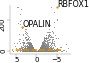

In [23]:
plt.figure(None, (1.1, 0.9))
ax = plt.subplot(111)

x = deseq['log2FoldChange']
y = np.copy(deseq['padj'])
# set 0 to the next minimum of the dataset 
y[y == 0] = deseq.query('padj != 0')['padj'].min()
y = -np.log10(y)
ax.scatter(x, y, s=1, lw=0, color='grey', rasterized=True)
ax.hlines(-np.log10(1e-5), -6, 6, linestyles='dashed', color=cbl[1])
for g in ['RBFOX1', 'OPALIN']:
    ix = deseq['Gene'] == g
    ax.scatter(x[ix], y[ix], s=5, lw=0, color=cbl[1])
    ax.text(x[ix], y[ix], g, fontsize=8)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
# plt.xlim(-6, 6)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7, rotation=90)
ax.invert_xaxis()
plt.savefig(f'{figure_folder}/volcano_oligo.pdf', dpi=300)

# Oligodendrocyte precursors

## Prepare pseudobulk counts from a balanced dataset

5000 cells sampled from each donor and type (30,000 cells total)

In [22]:
df = pd.read_csv('/proj/human_adult/20220222/harmony/revision/downsampled_opc_balanced.csv', index_col=0)
df.head()

,10X222_1:CTCTCGACAAGTCATC,10X389_3:TATCAGGTCAATCAGC,10X248_8:GTCGCGACAGAGTTCT,10X240_6:TACACCCCACTACGGC,10X221_6:GAGGCCTAGTGATTCC,10X241_1:GTAGGAGCATTGAAAG,10X276_7:GTCAAGTTCCACAGCG,10X249_6:GTAACACAGTTTGTCG,10X318_7:GTGTGGCAGCGCATCC,10X329_4:CCGATCTAGGGATCTG,...,10X375_3:ACGCACGTCATTGCCC,10X362_4:TCTTCCTTCGTTAGAC,10X362_4:TTCAGGATCGTCACCT,10X362_5:CGAGAAGAGCGAGAAA,10X362_5:GCATTAGGTATAGGAT,10X362_6:CTGTAGAGTAGTGCGA,10X419_2:GTCGTAAAGCCTCATA,10X362_3:TAAGCCAAGACCATAA,10X192_4:CATTGAGCACTGTCGG,10X194_4:TCACATTTCTCAATCT
HES5,0.0,0.0,3.0,0.0,2.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GPC5,4.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZNF736P9Y,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
APOE,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
LRRC3B,0.0,0.0,0.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean_OPCs.agg.loom', 'r') as ds:
    clades = hc.cut_tree(ds.attrs.linkage, 2)

with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean_OPCs.loom', 'r') as ds:

    # get indices for cells in .csv columns
    cell_dict = dict(zip(ds.ca.CellID, range(ds.shape[1])))
    selected_cells = np.array([cell_dict.get(x) for x in df.columns])

    # get labels
    labels = clades[ds.ca.Clusters].flatten()
    labels = labels[selected_cells]
    donors = ds.ca.Donor[selected_cells]

In [25]:
df = df.T

In [26]:
df['donor'] = donors
df['condition'] = labels

In [27]:
df.head()

,HES5,GPC5,ZNF736P9Y,APOE,LRRC3B,LINC01965,MIR3681HG,GPNMB,AL356737.2,SEMA6D,...,AC022634.2,VPS13B-DT,CEP164P1,UNC5C,KRT18P37,GABBR1,ASB18,ITIH2,donor,condition
10X222_1:CTCTCGACAAGTCATC,0.0,4.0,0.0,1.0,0.0,1.0,4.0,0.0,0.0,4.0,...,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,H18.30.002,0
10X389_3:TATCAGGTCAATCAGC,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,H19.30.001,0
10X248_8:GTCGCGACAGAGTTCT,3.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,H19.30.002,0
10X240_6:TACACCCCACTACGGC,0.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,H19.30.001,0
10X221_6:GAGGCCTAGTGATTCC,2.0,4.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,H18.30.002,0


In [28]:
balanced_df = df.groupby(['donor', 'condition'], as_index=False).aggregate('sum')
balanced_df.head()

,donor,condition,HES5,GPC5,ZNF736P9Y,APOE,LRRC3B,LINC01965,MIR3681HG,GPNMB,...,PCDHGB4,HIGD1AP18,AC022634.2,VPS13B-DT,CEP164P1,UNC5C,KRT18P37,GABBR1,ASB18,ITIH2
0,H18.30.002,0,3583.0,28274.0,551.0,1829.0,2787.0,4090.0,21754.0,2532.0,...,283.0,0.0,4.0,1241.0,26.0,21170.0,7.0,4487.0,54.0,29.0
1,H18.30.002,1,411.0,2323.0,9.0,420.0,241.0,639.0,7737.0,72.0,...,297.0,0.0,3.0,1389.0,30.0,15934.0,3.0,3813.0,60.0,27.0
2,H19.30.001,0,1601.0,9164.0,131.0,1157.0,1470.0,2826.0,9042.0,1986.0,...,146.0,0.0,1.0,756.0,28.0,7362.0,0.0,2454.0,132.0,24.0
3,H19.30.001,1,175.0,942.0,0.0,308.0,129.0,283.0,3487.0,212.0,...,117.0,1.0,0.0,826.0,39.0,6345.0,1.0,2121.0,107.0,30.0
4,H19.30.002,0,3173.0,27407.0,93.0,1943.0,1894.0,3132.0,9380.0,4035.0,...,175.0,0.0,4.0,1029.0,24.0,10826.0,1.0,3165.0,101.0,29.0


In [29]:
balanced_df['condition'] = balanced_df['condition'].astype('str').str.replace('0', 'Type0')
balanced_df['condition'] = balanced_df['condition'].astype('str').str.replace('1', 'Type1')
balanced_df.head()

,donor,condition,HES5,GPC5,ZNF736P9Y,APOE,LRRC3B,LINC01965,MIR3681HG,GPNMB,...,PCDHGB4,HIGD1AP18,AC022634.2,VPS13B-DT,CEP164P1,UNC5C,KRT18P37,GABBR1,ASB18,ITIH2
0,H18.30.002,Type0,3583.0,28274.0,551.0,1829.0,2787.0,4090.0,21754.0,2532.0,...,283.0,0.0,4.0,1241.0,26.0,21170.0,7.0,4487.0,54.0,29.0
1,H18.30.002,Type1,411.0,2323.0,9.0,420.0,241.0,639.0,7737.0,72.0,...,297.0,0.0,3.0,1389.0,30.0,15934.0,3.0,3813.0,60.0,27.0
2,H19.30.001,Type0,1601.0,9164.0,131.0,1157.0,1470.0,2826.0,9042.0,1986.0,...,146.0,0.0,1.0,756.0,28.0,7362.0,0.0,2454.0,132.0,24.0
3,H19.30.001,Type1,175.0,942.0,0.0,308.0,129.0,283.0,3487.0,212.0,...,117.0,1.0,0.0,826.0,39.0,6345.0,1.0,2121.0,107.0,30.0
4,H19.30.002,Type0,3173.0,27407.0,93.0,1943.0,1894.0,3132.0,9380.0,4035.0,...,175.0,0.0,4.0,1029.0,24.0,10826.0,1.0,3165.0,101.0,29.0


In [30]:
balanced_df.drop(['donor', 'condition'], axis=1).T.to_csv('opc_counts.csv')

In [31]:
balanced_df[['donor', 'condition']].to_csv('opc_coldata.csv')

## Run DESeq2 in R

## Analyze DESeq2 results

In [32]:
genes = pd.read_csv('/proj/human_adult/20220222/harmony/revision/downsampled_opc_balanced.csv', usecols=[0]).to_numpy().flatten()
genes

array(['HES5', 'GPC5', 'ZNF736P9Y', ..., 'GABBR1', 'ASB18', 'ITIH2'],
      dtype=object)

In [33]:
deseq = pd.read_csv('deseq_opc.csv')
deseq['Unnamed: 0'] = genes
deseq = deseq.rename({'Unnamed: 0': 'Gene'}, axis=1)

In [15]:
deseq.head()

,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,SLC27A6,355.258513,-2.474894,0.178804,-13.841384,1.434174e-43,1.372586e-41
1,LINC02823,53.727585,-5.036416,0.711662,-7.076975,1.473354e-12,3.030038e-11
2,PDE4B-AS1,327.619024,-0.305367,0.184920,-1.651345,9.866817e-02,2.571747e-01
3,MDFIC2,256.502087,-1.712814,0.202175,-8.471936,2.413474e-17,7.067165e-16
4,AL591115.1,1003.777599,-2.349817,0.589802,-3.984079,6.774229e-05,5.373919e-04


In [144]:
deseq[deseq['Gene'] == 'FOXG1']

,Gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
30514,FOXG1,387.670097,-4.848199,0.221968,-21.841859,9.289841e-106,1.526035e-102


In [36]:
deseq.query('padj < 1e-5').shape

(959, 7)

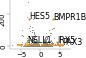

In [141]:
plt.figure(None, (1.1, 0.9))
ax = plt.subplot(111)

x = deseq['log2FoldChange']
y = np.copy(deseq['padj'])
# set 0 to the next minimum of the dataset 
y[y == 0] = deseq.query('padj != 0')['padj'].min()
y = -np.log10(y)
ax.scatter(x, y, s=1, lw=0, color='grey', rasterized=True)
ax.hlines(-np.log10(1e-5), -6, 6, linestyles='dashed', color=cbl[1])
for g in ['NELL1', 'HES5', 'PAX3', 'IRX5', 'BMPR1B']:
    ix = deseq['Gene'] == g
    ax.scatter(x[ix], y[ix], s=5, lw=0, color=cbl[1])
    ax.text(x[ix], y[ix], g, fontsize=8)
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
# plt.xlim(-6, 6)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7, rotation=90)
plt.savefig(f'{figure_folder}/volcano_opc.pdf', dpi=300)

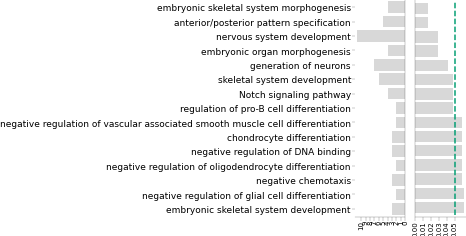

In [133]:
de_genes = deseq.query('padj < 1e-5').query('log2FoldChange < -2 | log2FoldChange > 2')['Gene'].to_list()
enr_table = gget.enrichr(de_genes, database="ontology")
go_plot(enr_table, 15, fig_size=(2, 4), filename=f'{figure_folder}/opc_GO_plot.pdf')

In [134]:
len(de_genes)

128

In [135]:
enr_table[:20]

,rank,path_name,p_val,z_score,combined_score,overlapping_genes,adj_p_val,database
0,1,embryonic skeletal system morphogenesis (GO:00...,0.000044,23.709677,237.813786,"[IRX5, HOXA3, HOXB3, HOXD3]",0.016508,GO_Biological_Process_2021
1,2,anterior/posterior pattern specification (GO:0...,0.000052,13.887020,137.030579,"[HOXA3, HOXB3, HES1, HOXD3, HES5]",0.016508,GO_Biological_Process_2021
2,3,nervous system development (GO:0007399),0.000143,4.191092,37.094134,"[CHRM3, NELL1, PPP1R17, SLITRK6, HES1, NPTX1, ...",0.028379,GO_Biological_Process_2021
3,4,embryonic organ morphogenesis (GO:0048562),0.000178,15.993548,138.065452,"[HOXA3, HOXB3, HES1, HOXD3]",0.028379,GO_Biological_Process_2021
4,5,generation of neurons (GO:0048699),0.000326,5.837635,46.871473,"[IRX5, LHX2, IRX3, EN1, CCK, HES1, HES5]",0.041509,GO_Biological_Process_2021
5,6,skeletal system development (GO:0001501),0.000542,6.380500,47.977269,"[EN1, HOXD3, BMPR1B, PAPSS2, HES5, HAPLN1]",0.047731,GO_Biological_Process_2021
6,7,Notch signaling pathway (GO:0007219),0.000592,11.414747,84.842822,"[HES1, MAML3, HOXD3, HES5]",0.047731,GO_Biological_Process_2021
7,8,regulation of pro-B cell differentiation (GO:2...,0.000599,78.841270,584.963503,"[HES1, HES5]",0.047731,GO_Biological_Process_2021
8,9,negative regulation of oligodendrocyte differe...,0.000836,63.069841,446.990813,"[HES1, HES5]",0.058902,GO_Biological_Process_2021
9,10,negative regulation of DNA binding (GO:0043392),0.001010,17.009143,117.332486,"[MSX2, HMGA2, MDFI]",0.058902,GO_Biological_Process_2021


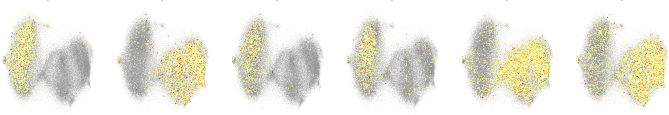

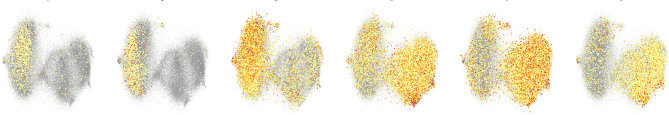

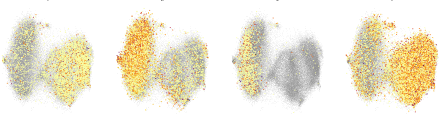

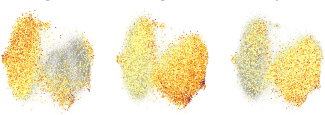

In [140]:
for n in [4, 5, 6, 12]:

    with loompy.connect('/proj/human_adult/20220222/harmony/analysis/data/oligolineage_Clean_OPCs.loom', 'r') as ds:

        plt.figure(None, (12, 2))
        gs = plt.GridSpec(1, 6)

        to_plot = enr_table.loc[n, 'overlapping_genes'][:6]

        for i, g in enumerate(to_plot):
            plt.subplot(gs[i])
            exp = np.log2(ds[np.where(ds.ra.Gene == g)[0][0], :].flatten() + 1)
            cells = exp > 0

            plt.scatter(ds.ca.TSNE[:, 0], ds.ca.TSNE[:, 1], color='grey', alpha=0.05, s=1, lw=0, rasterized=True)
            plt.scatter(ds.ca.TSNE[cells, 0], ds.ca.TSNE[cells, 1], c=exp[cells], s=1, lw=0, rasterized=True, cmap='inferno_r')

            plt.title(g, fontsize=0.5)
            plt.axis('off')
            plt.margins(0.02, 0.02)
        
        plt.savefig(f'{figure_folder}/opc_overlapping_genes_{n}.pdf', dpi=300)